In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

#%matplotlib widget
#import ipywidgets as widgets
#import ipympl


plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
def add_derived_columns(df):                               # step 1: add JID and standartize timestamps 
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler() # to standardize the timestamp
    for cname in ('timestamp'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

In [3]:
def sample_campaigns(df, n_campaigns):                     # step 2.1: reduce the dataset by sampling campaigns
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False ) # randomly samples the data
    return df[ df['campaign'].isin(campaigns) ]

In [4]:
def filter_journeys_by_length(df, min_touchpoints):        # step 2.2: remove short (trivial) journeys
    grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
    return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

In [5]:
df2 = pd.read_csv("/Users/rohittikle/Downloads/A3P2/df2.csv")
#df2.head()

In [6]:
df3 = filter_journeys_by_length(df2, 1) # as count of jid is min when we put 2 it doesn't show any results after grouping
#df3.head(20)

In [7]:
def balance_conversions(df):                               # step 3: balance the dataset: 
    df_minority = df[df.conversion == 1]                   # The number of converted and non-converted events should be equal.
    df_majority = df[df.conversion == 0]                   # We take all converted journeys and iteratively add non-converted 
                                                           # samples until the datset is balanced. We do it this way becasue  
    df_majority_jids = np.array_split(                     # we are trying to balance the number of events, but can add only
          df_majority['jid'].unique(),                     # the whole journeys.
          100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([
            df_majority_sampled, 
            df_majority[df_majority.jid.isin(jid_chunk)]
        ])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

In [8]:
df4 = balance_conversions(df3) # the generated output has 13 rows with 6 converted and 7  non converted
#df4.head(20) 

In [9]:
def map_one_hot(df, column_names, result_column_name):      # step 4: one-hot encoding for categorical variables
    mapper = {}                                             # We use custom mapping becasue IDs in the orginal dataset
    for i, col_name in enumerate(column_names):             # are not sequential, and standard one-not encoding 
        for val in df[col_name].unique():                   # provided by Keras does not handle this properly.
            mapper[val*10 + i] = len(mapper)
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            mapped_val_id = mapper[val*10 + i]
            v[mapped_val_id] = 1
        return v    
    
    df_ext = df.copy()
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [10]:
# all categories are mapped to one vector  
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats') #added vector cats 

In [11]:
# the final dataframe used for modeling  
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm']) 

         jid
count       
1      16448
2       4757
3       2161
4       1273
5        800
6        515
7        391
8        307
9        229
10       157
11       150
12       102
13        94
14        64
15        54
16        57
17        37
18        25
19        34
20        23
21        25
22        12
23        10
24        10
25        14
26        10
27        11
28         9
29        10
30         4
31         1
32         4
33         4
34         1
35         1
36         1
37         3
38         2
40         3
41         2
42         2
45         3
49         2
50         1
56         1
59         1
60         1
62         1
74         1
96         1
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 40, 41, 42, 45, 49, 50, 56, 59, 60, 62, 74, 96],
           dtype='int64', name='count')
[[16448]
 [ 4757]
 [ 2161]
 [ 1273]
 [  800]
 [

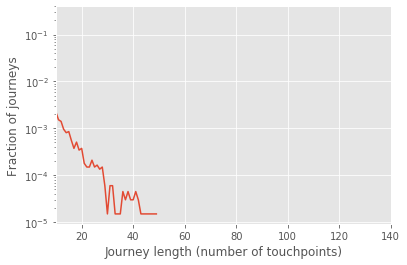

In [12]:
# Data exploration

def journey_length_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count() #grouping all the counts of jid 
    print(counts)
    print(counts.index)
    print(counts.values)
    return counts.index, counts.values / df.shape[0] #df.shape() Returns tuple of shape (Rows, columns) of dataframe/series

hist_x, hist_y = journey_length_histogram(df4)

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(10,140 )
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()


#This returns the number of times one journey has occured

#The dataset contains journeys with up to 40 events(number of touchpoints) or more, but the number of journeys falls exponentially with the length:
#The number of journeys with several events is considerable; thus, it makes sense to try methods for sequential data.
# this means there is one user id who has impressions of 40 and the

In [13]:
counts = df6.groupby(['jid'])['campaign'].count().reset_index(name="count")
print(counts)

                     jid  count
0            10000139_-1      1
1      10000523_19113736      4
2      10000523_22688888      1
3       10000523_2559380      3
4             1000054_-1      1
...                  ...    ...
27824    9992596_2653687      1
27825   9992944_26284453      1
27826         9993250_-1      1
27827         9997400_-1      1
27828    9998038_1380314      1

[27829 rows x 2 columns]


In [14]:
counts = df4.groupby(['jid'])['uid'].count().reset_index(name="count")
counts

,jid,count
0,10000139_-1,1
1,10000523_19113736,4
2,10000523_22688888,1
3,10000523_2559380,3
4,1000054_-1,1
...,...,...
27824,9992596_2653687,1
27825,9992944_26284453,1
27826,9993250_-1,1
27827,9997400_-1,1


# Last Touch Attribution

In [15]:
n_campaigns = 20
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot) # maximum argument in given array
            #print(campaign_id)
            counters[campaign_id] = counters[campaign_id] + 1 
            #print(counters)
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print('campaign_impressions')
    print(campaign_impressions) #gives count of total campaigns
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    #print(df_converted[idx]) #forms a dataframe of all the campaigns that are converted and have maximum timestamp
    campaign_conversions = count_by_campaign(df_converted[idx])
    print('campaign_conversions with last time stamp for that Jid')
    print(campaign_conversions) #gives count of campaigns that are at max timestamp and are converted
    print('campaign_conversions / campaign_impressions')    
    print(campaign_conversions / campaign_impressions)    
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

campaign_impressions
[21835.  2367.  9744. 11873.  6651.  1531.   183.   735.  1808.  2132.
  1325.  2425.   700.   828.   308.   546.  1196.   276.   206.    68.]
campaign_conversions with last time stamp for that Jid
[5008.  270. 4444. 3087. 1385.  502.   55.   60.  943.   99.   98. 1315.
   97.  136.   52.  354.  694.   36.   53.   25.]
campaign_conversions / campaign_impressions
[0.22935654 0.11406844 0.45607553 0.26000168 0.20823936 0.32789027
 0.30054645 0.08163265 0.5215708  0.04643527 0.07396226 0.54226804
 0.13857143 0.16425121 0.16883117 0.64835165 0.58026756 0.13043478
 0.25728155 0.36764706]


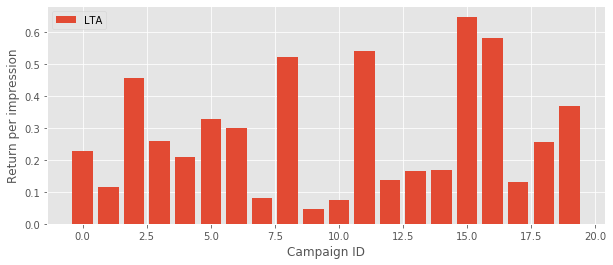

In [16]:
# Visualization of the attribution scores

campaign_idx = range(0, 20)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [17]:
fig.canvas.toolbar_visible = True
fig.canvas.header_visible = True
fig.canvas.footer_visible = True

# First Touch Attribution

In [18]:
n_campaigns = 20
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot) # maximum argument in given array
            #print(campaign_id)
            counters[campaign_id] = counters[campaign_id] + 1 
            #print(counters)
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print('campaign_impressions')
    print(campaign_impressions) #gives count of total campaigns
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    #print(df_converted[idx]) #forms a dataframe of all the campaigns that are converted and have maximum timestamp
    campaign_conversions = count_by_campaign(df_converted[idx])
    print('campaign_conversions with last time stamp for that Jid')
    print(campaign_conversions) #gives count of campaigns that are at max timestamp and are converted
    print('campaign_conversions / campaign_impressions')    
    print(campaign_conversions / campaign_impressions)    
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

campaign_impressions
[21835.  2367.  9744. 11873.  6651.  1531.   183.   735.  1808.  2132.
  1325.  2425.   700.   828.   308.   546.  1196.   276.   206.    68.]
campaign_conversions with last time stamp for that Jid
[5008.  270. 4444. 3087. 1385.  502.   55.   60.  943.   99.   98. 1315.
   97.  136.   52.  354.  694.   36.   53.   25.]
campaign_conversions / campaign_impressions
[0.22935654 0.11406844 0.45607553 0.26000168 0.20823936 0.32789027
 0.30054645 0.08163265 0.5215708  0.04643527 0.07396226 0.54226804
 0.13857143 0.16425121 0.16883117 0.64835165 0.58026756 0.13043478
 0.25728155 0.36764706]


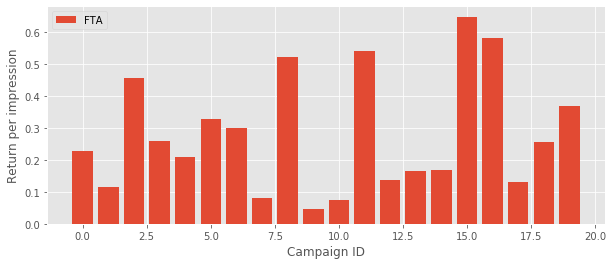

In [19]:
# Visualization of the attribution scores

campaign_idx = range(0, 20)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Logistic Regression

In [20]:
# Logistic regression
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [21]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(27829, 177)


In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [23]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8212360761767876


/Users/rohittikle/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 17810 samples, validate on 4453 samples
Epoch 1/10
17810/17810 [==============================] - 0s 15us/step - loss: 0.6384 - accuracy: 0.6518 - val_loss: 0.5798 - val_accuracy: 0.7328
Epoch 2/10
17810/17810 [==============================] - 0s 9us/step - loss: 0.5502 - accuracy: 0.7509 - val_loss: 0.5300 - val_accuracy: 0.7523
Epoch 3/10
17810/17810 [==============================] - 0s 9us/step - loss: 0.5129 - accuracy: 0.7704 - val_loss: 0.5043 - val_accuracy: 0.7629
Epoch 4/10
17810/17810 [==============================] - 0s 9us/step - loss: 0.4931 - accuracy: 0.7771 - val_loss: 0.4893 - val_accuracy: 0.7676
Epoch 5/10
17810/17810 [==============================] - 0s 10us/step - loss: 0.4809 - accuracy: 0.7801 - val_loss: 0.4795 - val_accuracy: 0.7725
Epoch 6/10
17810/17810 [==============================] - 0s 11us/step - loss: 0.4726 - accuracy: 0.7824 - val_loss: 0.4719 - val_accuracy: 0.7730
Epoch 7/10
17810/17810 [==============================] - 0s 9us/step - 

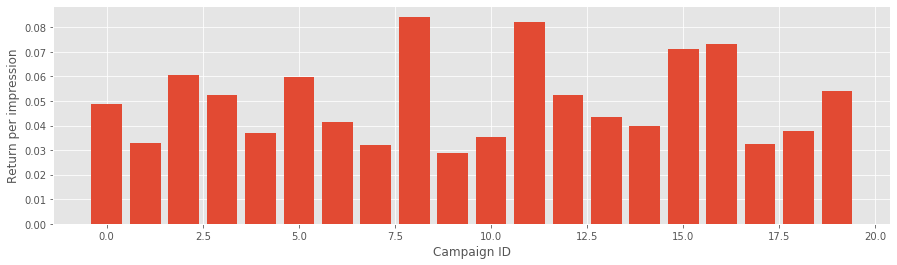

In [25]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

# Linear Regression

In [26]:
n_campaigns = 20
def linear(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot) # maximum argument in given array
            #print(campaign_id)
            counters[campaign_id] = counters[campaign_id] + 1 
            #print(counters)
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print('campaign_impressions')
    print(campaign_impressions) #gives count of total campaigns
    
    df_converted = df[df['conversion'] == 1]
    #df.groupby('Item')['Price'].transform(lambda x: x.value_counts().idxmax())
    idx = df_converted.groupby(['jid'])['campaign'].transform(lambda x: x.value_counts().idxmax()) == df_converted['campaign']
    campaign_conversions = count_by_campaign(df_converted[idx])
    print('campaign_conversions')
    print(campaign_conversions) #gives count of campaigns that are at max timestamp and are converted
    print('campaign_conversions / campaign_impressions')    
    print(campaign_conversions / campaign_impressions)    
    return 1 / campaign_conversions
    
lin = linear(df6)

campaign_impressions
[21835.  2367.  9744. 11873.  6651.  1531.   183.   735.  1808.  2132.
  1325.  2425.   700.   828.   308.   546.  1196.   276.   206.    68.]
campaign_conversions
[10575.   413.  7176.  6006.  2175.  1017.    76.    80.  1519.   213.
   275.  1835.   247.   286.    82.   426.   814.    50.    63.    37.]
campaign_conversions / campaign_impressions
[0.48431417 0.17448247 0.7364532  0.50585362 0.32701849 0.66427172
 0.41530055 0.10884354 0.84015487 0.09990619 0.20754717 0.75670103
 0.35285714 0.34541063 0.26623377 0.78021978 0.68060201 0.18115942
 0.30582524 0.54411765]


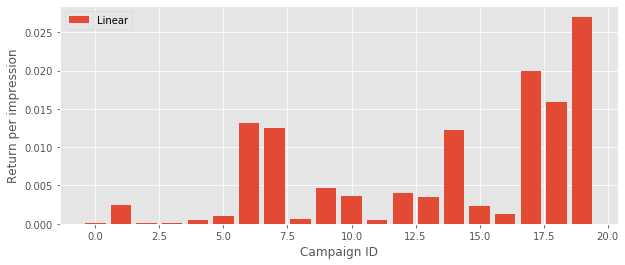

In [27]:
# Visualization of the attribution scores

campaign_idx = range(0, 20)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
plt.bar(range(len(lin[campaign_idx])), lin[campaign_idx], label='Linear' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Budget Optimization

In [28]:
def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [29]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [30]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta,fta,keras_logreg,lin]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

0 0 : 2047
0 1 : 2047
0 2 : 2006
0 3 : 1801
1 0 : 2148
1 1 : 2148
1 2 : 2076
1 3 : 1550
2 0 : 2314
2 1 : 2314
2 2 : 2193
2 3 : 1140
3 0 : 2647
3 1 : 2647
3 2 : 2413
3 3 : 626
4 0 : 2833
4 1 : 2833
4 2 : 2637
4 3 : 414
5 0 : 2927
5 1 : 2927
5 2 : 2908
5 3 : 336
6 0 : 2962
6 1 : 2962
6 2 : 3180
6 3 : 303
7 0 : 2968
7 1 : 2968
7 2 : 3499
7 3 : 277
